In [1]:
import time
import sklearn
print("Version sklearn : ", sklearn.__version__)

import numpy as np 
import pandas as pd

from tqdm.notebook import tqdm # progress bar

# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


Version sklearn :  1.5.2


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_colwidth", None)

In [3]:
# Load data
input_df = pd.read_csv("input_df.csv", index_col=0)
input_df_pca = pd.read_csv("input_df_pca.csv", index_col=0)
output_df_class = pd.read_csv("output_df_class.csv", index_col=0)
output_df_score = pd.read_csv("output_df_score.csv", index_col=0)

In [4]:
# Drop rows with missing values in the output for supervised learning

supervised_learning_mask = output_df_score.notna().all(axis=1)

input_df = input_df[supervised_learning_mask]
input_df_pca = input_df_pca[supervised_learning_mask]
output_df_class = output_df_class[supervised_learning_mask]
output_df_score = output_df_score[supervised_learning_mask]

In [5]:
# Prepare input data
X_base = input_df.values
X_pca = input_df_pca.values
y = output_df_class.values

# Set a random seed for reproducibility
random_state = 123

# Define cross-validation strategy
kf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)

# Define a scoring metric
scoring = ["accuracy", "f1_micro", "f1_macro", "precision_macro", "recall_macro"]


from sklearn.metrics import precision_score, make_scorer

# Custom precision scorer to handle cases where a label has never been seen py the predictor (division by tp + fp = 0)
precision_macro_scorer = make_scorer(precision_score, zero_division=0, average="macro") 
custom_scoring = {"accuracy": "accuracy", 
                  "f1_micro": "f1_micro",
                  "f1_macro": "f1_macro",
                  "precision_macro": precision_macro_scorer,
                  "recall_macro": "recall_macro"}

In [6]:
# Define models and hyperparameters for tuning
models = {
    "K-Nearest Neighbors Classifier (uniform)": {
        "model": KNeighborsClassifier(),
        "params": {"k-nearestneighborsclassifier(uniform)__n_neighbors": [2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 35, 40, 50],
                   "k-nearestneighborsclassifier(uniform)__weights": ["uniform"]},
    },
    "K-Nearest Neighbors Classifier (distance)": {
        "model": KNeighborsClassifier(),
        "params": {"k-nearestneighborsclassifier(distance)__n_neighbors": [2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 35, 40, 50],
                   "k-nearestneighborsclassifier(distance)__weights": ["distance"],
                   "k-nearestneighborsclassifier(distance)__p": [1, 2, 3]},
    },
    "Support Vector Classifier (linear)": {
        "model": SVC(),
        "params": {
            "supportvectorclassifier(linear)__C": [0.1, 1.0, 10.0, 100.0],
            "supportvectorclassifier(linear)__kernel": ["linear"]
        },
    },
    "Support Vector Classifier (poly)": {
        "model": SVC(),
        "params": {
            "supportvectorclassifier(poly)__C": [0.1, 1.0, 10.0, 100.0],
            "supportvectorclassifier(poly)__kernel": ["poly"],
            "supportvectorclassifier(poly)__gamma": [0.01, 0.1, 0.5],
            "supportvectorclassifier(poly)__degree": [2, 3, 4, 5],
        },
    },
    "Support Vector Classifier (rbf)": {
        "model": SVC(),
        "params": {
            "supportvectorclassifier(rbf)__C": [0.1, 1.0, 10.0, 100.0],
            "supportvectorclassifier(rbf)__kernel": ["rbf"],
            "supportvectorclassifier(rbf)__gamma": [0.01, 0.1, 0.5],
        },
    },
    "Decision Tree Classifier": {
        "model": DecisionTreeClassifier(),
        "params": {
            "decisiontreeclassifier__max_depth": [5, 10, 15],
            "decisiontreeclassifier__min_samples_split": [2, 5, 10]
        },
    },
    "Bagging Classifier": {
        "model": BaggingClassifier(random_state=42),
        "params": {
            "baggingclassifier__n_estimators": [50, 100, 150],
            "baggingclassifier__max_samples": [0.5, 0.8, 1.0],
            "baggingclassifier__max_features": [0.5, 0.8, 1.0]
        },
    },
    "Random Forest Classifier": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "randomforestclassifier__n_estimators": [10, 50, 100],
            "randomforestclassifier__max_depth": [5, 10],
            "randomforestclassifier__min_samples_split": [2, 5],
        },
    }
}

In [7]:
# Function to clean the best params dictionary
def clean_params(params):
    return ", ".join(f"{key.split('__')[1]}: {value}" for key, value in params.items())

# Function to convert the one hot encoding back to multiclass ecoding
def one_hot_encoding_to_multiclass(y):
    return np.einsum('ij,j->i',y,np.arange(1,y.shape[1]+1))

In [8]:
# 1 dimension multiclass label
y_formated = one_hot_encoding_to_multiclass(y)

# Create an empty list to store results
results_list_base_input, model_list_base_input = [], []
results_list_pca_input, model_list_pca_input = [], []

input_setups = {"Base input": (X_base, results_list_base_input, model_list_base_input),
                "PCA input": (X_pca, results_list_pca_input, model_list_pca_input)}

# Test models on base input and pca-preprocessed input
for input_name, input_config in input_setups.items():
    
    X, results_list, model_list = input_config
    
    fold_1 = kf.split(X,y_formated)
    fold_1_train_index, fold_1_test_index = next(fold_1)
    X_train, y_train, X_test, y_test = X[fold_1_train_index], y_formated[fold_1_train_index], X[fold_1_test_index], y_formated[fold_1_test_index]
    
    print(f"Starting GridSearch with [{input_name}] ...")
    
    # Loop over each model
    for model_name, config in tqdm(models.items()):
        print(f"Training and tuning {model_name}...")

        # Track start time
        start_time = time.time()

        # Create a pipeline with StandardScaler (necessary for some models)    
        pipeline = Pipeline([
                (
                    "scaler",
                    StandardScaler(),
                ),
                (model_name.lower().replace(" ", ""), config["model"]),
            ])
        
        # Set up GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=config["params"],
            cv=kf,
            scoring=custom_scoring,
            refit="f1_macro",
            return_train_score=False,
            verbose=1,
        )

        # Fit the grid search
        grid_search.fit(X, y_formated)
        
        # Index of best estimator (on average score metric over splits)
        best_predictor_index = grid_search.best_index_
        
        # print(grid_search.cv_results_) # DEBUG
        
        # Append results to list
        results_list.append(
            {
                "Model Name": model_name,
                "Best Params": clean_params(grid_search.best_params_),
                "Accuracy": grid_search.cv_results_["mean_test_accuracy"][best_predictor_index],
                "F1-score (micro)": grid_search.cv_results_["mean_test_f1_micro"][best_predictor_index],
                "F1-score (macro)": grid_search.cv_results_["mean_test_f1_macro"][best_predictor_index],
                "Precision (macro)": grid_search.cv_results_["mean_test_precision_macro"][best_predictor_index],
                "Recal (macro)": grid_search.cv_results_["mean_test_recall_macro"][best_predictor_index]
            }
        )
        
        # Get best estimator
        best_est = grid_search.best_estimator_
        
        best_est.fit(X_train, y_train) # refit only on 1st fold train set
        y_pred = best_est.predict(X_test)
        
        # Append results to list
        model_list.append(
            {
                "Model Name": model_name,
                "gc": grid_search,
                "conf_mat_on_fold": confusion_matrix(y_test, y_pred, normalize='true')
            }
        )

    # Print duration
    print(f"Done in {time.time() - start_time:.2f} seconds\n")


Starting GridSearch with [Base input] ...


  0%|          | 0/8 [00:00<?, ?it/s]

Training and tuning K-Nearest Neighbors Classifier (uniform)...
Fitting 10 folds for each of 13 candidates, totalling 130 fits


c:\Users\Elian\AppData\Local\pypoetry\Cache\virtualenvs\apprauto-hv_gZX10-py3.12\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Training and tuning K-Nearest Neighbors Classifier (distance)...
Fitting 10 folds for each of 39 candidates, totalling 390 fits
Training and tuning Support Vector Classifier (linear)...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Training and tuning Support Vector Classifier (poly)...
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Training and tuning Support Vector Classifier (rbf)...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Training and tuning Decision Tree Classifier...
Fitting 10 folds for each of 9 candidates, totalling 90 fits


c:\Users\Elian\AppData\Local\pypoetry\Cache\virtualenvs\apprauto-hv_gZX10-py3.12\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Training and tuning Bagging Classifier...
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Training and tuning Random Forest Classifier...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Done in 13.47 seconds

Starting GridSearch with [PCA input] ...


  0%|          | 0/8 [00:00<?, ?it/s]

Training and tuning K-Nearest Neighbors Classifier (uniform)...
Fitting 10 folds for each of 13 candidates, totalling 130 fits
Training and tuning K-Nearest Neighbors Classifier (distance)...
Fitting 10 folds for each of 39 candidates, totalling 390 fits
Training and tuning Support Vector Classifier (linear)...
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Training and tuning Support Vector Classifier (poly)...
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Training and tuning Support Vector Classifier (rbf)...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Training and tuning Decision Tree Classifier...
Fitting 10 folds for each of 9 candidates, totalling 90 fits


c:\Users\Elian\AppData\Local\pypoetry\Cache\virtualenvs\apprauto-hv_gZX10-py3.12\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Training and tuning Bagging Classifier...
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Training and tuning Random Forest Classifier...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Done in 13.16 seconds



In [9]:
pd.DataFrame(results_list_base_input).sort_values("F1-score (macro)", ascending=False, ignore_index=True)

,Model Name,Best Params,Accuracy,F1-score (micro),F1-score (macro),Precision (macro),Recal (macro)
0,Bagging Classifier,"max_features: 0.8, max_samples: 1.0, n_estimators: 100",0.766514,0.766514,0.752403,0.789107,0.735461
1,Support Vector Classifier (rbf),"C: 10.0, gamma: 0.1, kernel: rbf",0.734014,0.734014,0.723128,0.740167,0.714726
2,K-Nearest Neighbors Classifier (distance),"n_neighbors: 7, p: 1, weights: distance",0.723053,0.723053,0.716400,0.734430,0.711048
3,Random Forest Classifier,"max_depth: 10, min_samples_split: 2, n_estimators: 100",0.738654,0.738654,0.714508,0.789732,0.688122
4,Support Vector Classifier (poly),"C: 1.0, degree: 3, gamma: 0.1, kernel: poly",0.715553,0.715553,0.692885,0.730991,0.678017
5,K-Nearest Neighbors Classifier (uniform),"n_neighbors: 4, weights: uniform",0.659832,0.659832,0.652284,0.683850,0.650609
6,Decision Tree Classifier,"max_depth: 15, min_samples_split: 10",0.659952,0.659952,0.644914,0.656499,0.642149
7,Support Vector Classifier (linear),"C: 1.0, kernel: linear",0.633678,0.633678,0.612280,0.635787,0.602941


In [10]:
pd.DataFrame(results_list_pca_input).sort_values("F1-score (macro)", ascending=False, ignore_index=True)

,Model Name,Best Params,Accuracy,F1-score (micro),F1-score (macro),Precision (macro),Recal (macro)
0,K-Nearest Neighbors Classifier (distance),"n_neighbors: 3, p: 1, weights: distance",0.625793,0.625793,0.598644,0.619426,0.590679
1,Bagging Classifier,"max_features: 1.0, max_samples: 1.0, n_estimators: 100",0.628846,0.628846,0.595316,0.620057,0.587093
2,Support Vector Classifier (rbf),"C: 10.0, gamma: 0.5, kernel: rbf",0.599567,0.599567,0.565025,0.597229,0.557043
3,Decision Tree Classifier,"max_depth: 15, min_samples_split: 10",0.590433,0.590433,0.563248,0.570699,0.563727
4,Random Forest Classifier,"max_depth: 10, min_samples_split: 2, n_estimators: 100",0.611923,0.611923,0.561941,0.616086,0.549926
5,K-Nearest Neighbors Classifier (uniform),"n_neighbors: 3, weights: uniform",0.577837,0.577837,0.548413,0.576057,0.545954
6,Support Vector Classifier (poly),"C: 10.0, degree: 3, gamma: 0.5, kernel: poly",0.576538,0.576538,0.546084,0.565019,0.541145
7,Support Vector Classifier (linear),"C: 100.0, kernel: linear",0.564183,0.564183,0.441097,0.535097,0.460768


In [11]:
print("\n".join(clean_params(model_list_pca_input[0]["gc"].best_params_).split(", ")))

n_neighbors: 3
weights: uniform


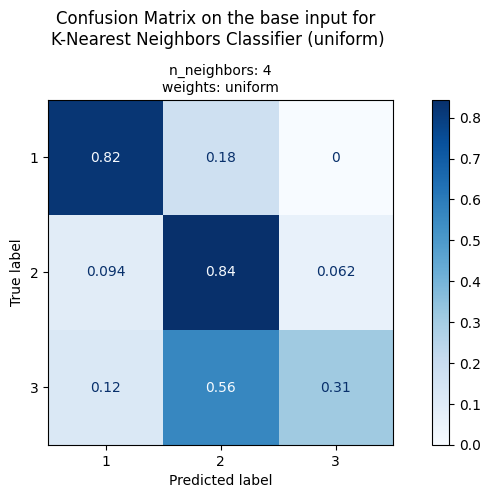

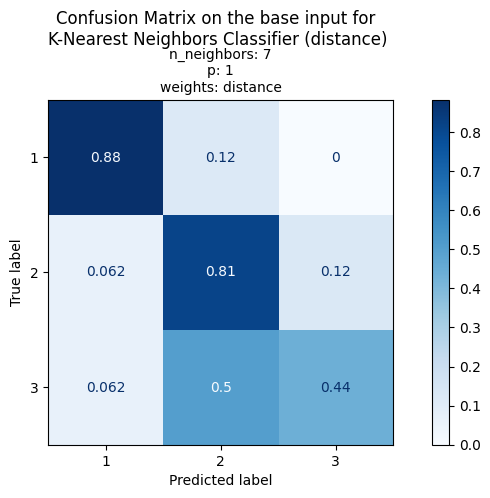

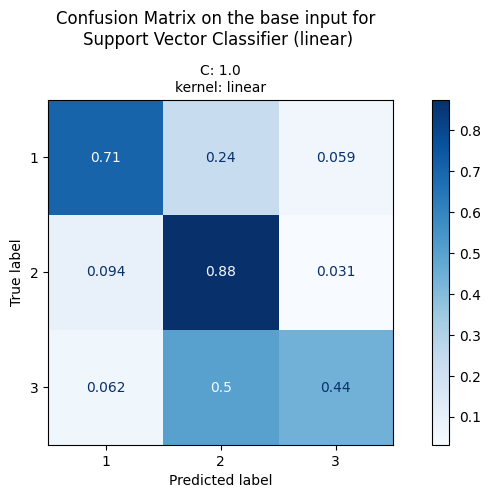

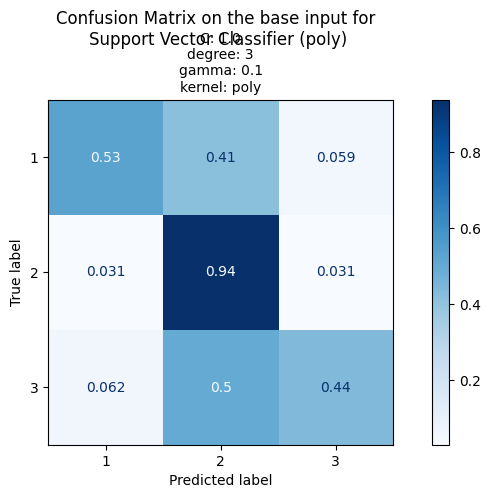

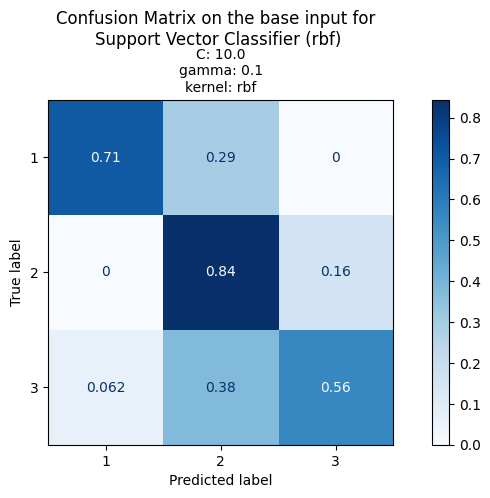

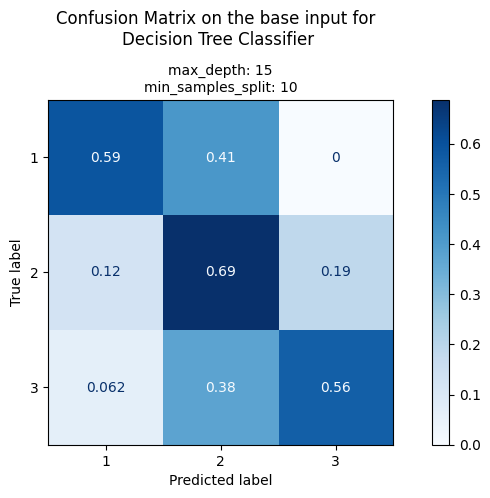

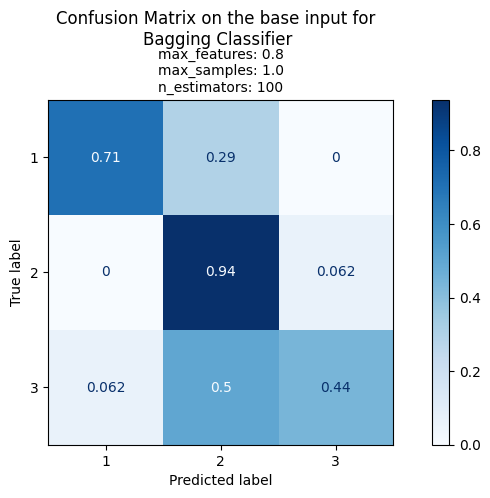

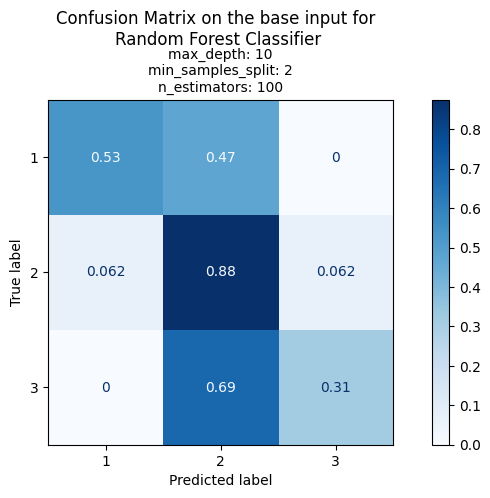

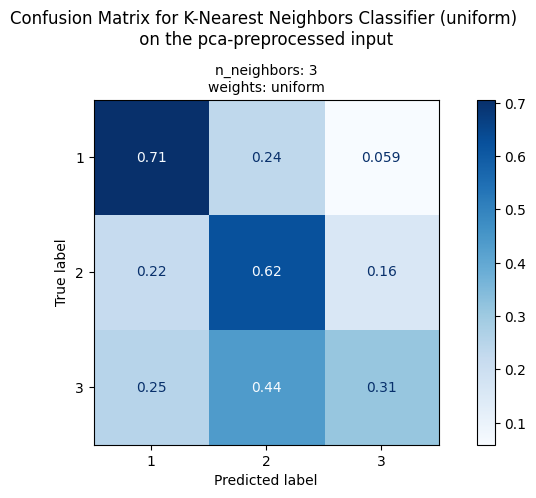

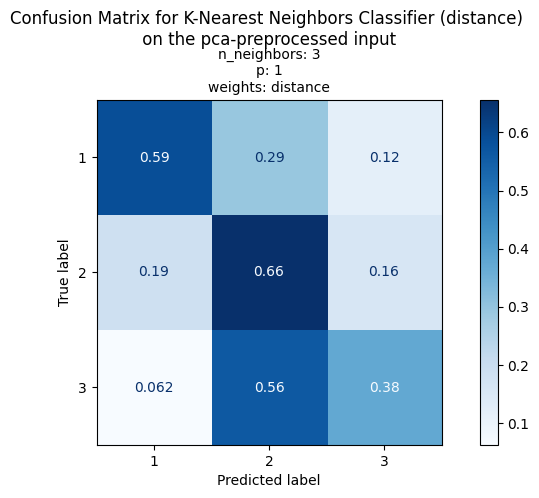

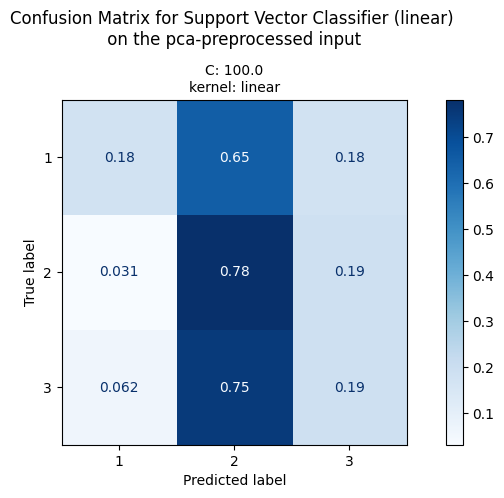

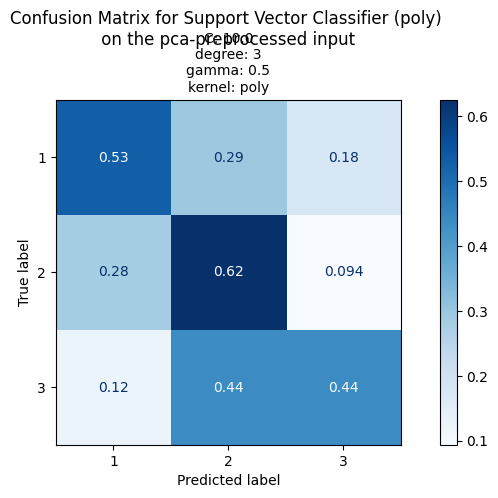

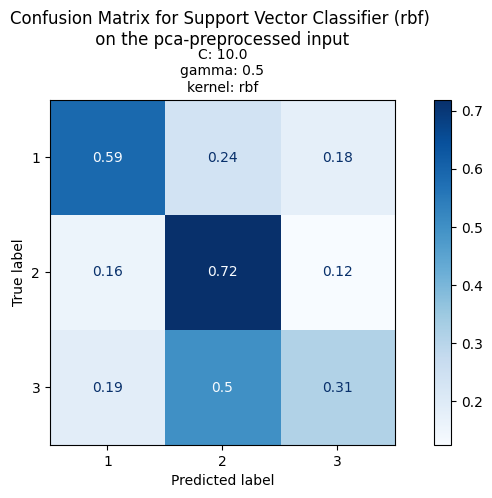

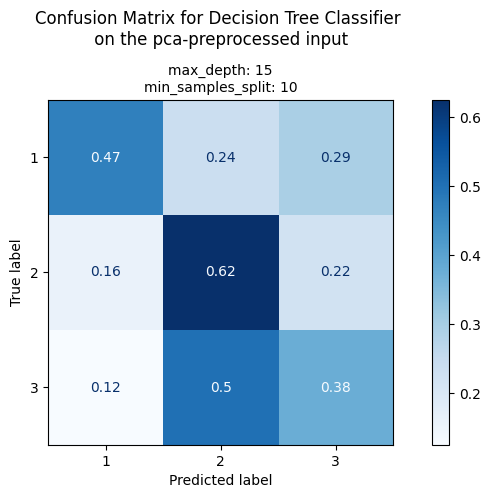

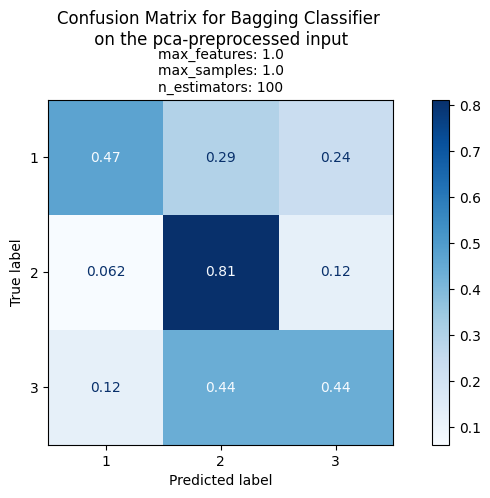

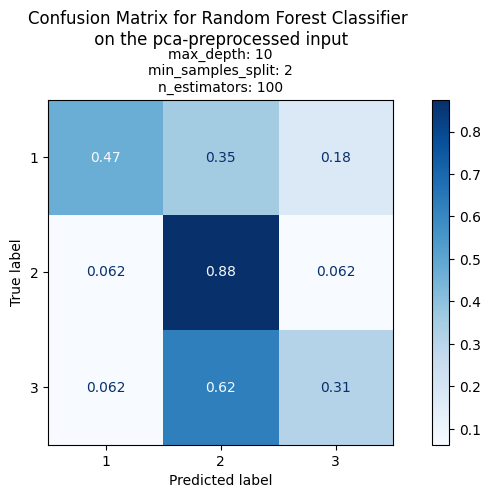

In [12]:
# Visualize confusion matrices :

import matplotlib.pyplot as plt

for model_res in model_list_base_input:
    conf_mat = model_res["conf_mat_on_fold"]
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.subplots_adjust(top=0.8)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[1,2,3])
    ax.set_title("\n".join(clean_params(model_res["gc"].best_params_).split(", ")), fontsize=10)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    fig.suptitle(f"Confusion Matrix on the base input for \n{model_res['Model Name']}", x=0.57)
    plt.show()
    
for model_res in model_list_pca_input:
    conf_mat = model_res["conf_mat_on_fold"]
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.subplots_adjust(top=0.8)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[1,2,3])
    ax.set_title("\n".join(clean_params(model_res["gc"].best_params_).split(", ")), fontsize=10)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    fig.suptitle(f"Confusion Matrix for {model_res['Model Name']}\n on the pca-preprocessed input", x=0.57)
    plt.show()